<center><h1>Verbal Autopsy Clustering</h1></center>

## Table of Contents
* [](#chapter1)
    * [Section 1.1](#section_1_1)
        * [Sub Section 1.1.1](#sub_section_1_1_1)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
    * [Section 2.2](#section_2_2)
        * [Sub Section 2.2.1](#sub_section_2_2_1)
        * [Sub Section 2.2.2](#sub_section_2_2_2)
* [Chapter 3](#chapter3)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)
        * [Sub Section 3.2.2](#sub_section_3_2_2)

<hr>

<h2>Bibliografia de momento</h2>

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

https://www.researchgate.net/publication/339529230_Preprocessing_Techniques_for_Text_Mining_-_An_Overview

<hr>

<h2>Presentacion de datos</h2>

Primero vamos a importar todo lo necesario para llevar a cabo la tarea de clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import contractions
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem import PorterStemmer
import seaborn as sb

Antes de empezar debemos crear un objeto a partir del archivo .csv que hemos escogido.

In [38]:
data = pd.read_csv("data/cleaned_PHMRC_VAI_redacted_free_text.train.csv")

Una vez creado aqui tenemos un pequeño ejemplo de lo que esta compuesto.

In [3]:
data.tail(5)

,newid,module,age,sex,site,open_response,gs_text34
5204,7120,Adult,42.0,1,UP,the deceased fell ill in the morning his breat...,Diabetes
5205,6101,Adult,14.0,2,Pemba,the respondant expained that the decease death...,Other Infectious Diseases
5206,6455,Adult,80.0,2,UP,the deceased had been admitted to hospital whe...,Pneumonia
5207,5026,Adult,70.0,1,UP,the deceased had been suffering from breathing...,Other Cardiovascular Diseases
5208,5326,Adult,30.0,1,Dar,the deceased died because of being hitted by a...,Other Injuries


Primero valoraremos si alguna de las instancias tiene algun valor null.

In [4]:
data_null = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5209 entries, 0 to 5208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   newid          5209 non-null   int64  
 1   module         5209 non-null   object 
 2   age            5209 non-null   float64
 3   sex            5209 non-null   int64  
 4   site           5209 non-null   object 
 5   open_response  5209 non-null   object 
 6   gs_text34      5209 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 285.0+ KB


No se aprecia ninguna entidad con valor null.

<h3>Representación gráfica</h3>

<BarContainer object of 48 artists>

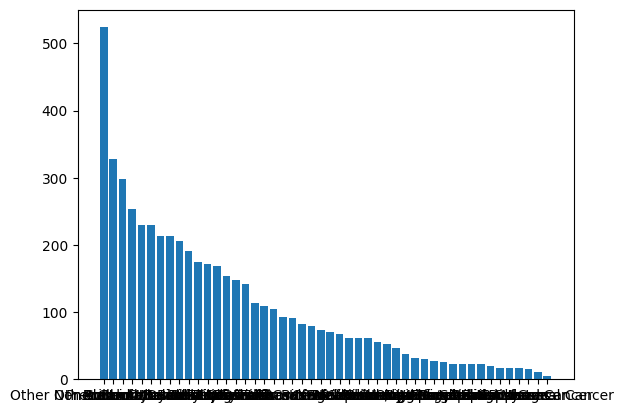

In [5]:
gs_text34 = data['gs_text34'].copy()
#plt.rcParams['figure.figsize'] = [40, 5]
plt.bar(gs_text34.value_counts().index, gs_text34.value_counts())

Al haber 48 tipos de muertes en el archivo .csv no se llega a apreciar bien la informacion. Por lo tanto vamos a hacer grafico mas pequeño para poder entenderlo mejor

<BarContainer object of 10 artists>

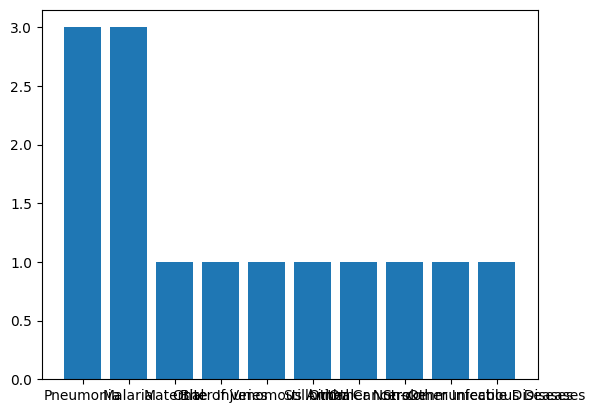

In [6]:
little_gs_text34 = gs_text34[0:14]
plt.bar(little_gs_text34.value_counts().index, little_gs_text34.value_counts())

Seleccionando solamente las 15 primera instancias del archivo .csv podemos apreciar que han habido 10 tipos diferentes de muerte y que solo dos de ellas se han repetido, en este caso 3 veces; Pneumonia y Malaria. 

<h3>Ver clases presentes y cadencia de cada una</h3>

In [7]:
print(data.groupby('gs_text34').size())

gs_text34
AIDS                                    154
Acute Myocardial Infarction             206
Asthma                                   17
Birth asphyxia                          171
Bite of Venomous Animal                  61
Breast Cancer                            62
COPD                                     80
Cervical Cancer                          22
Cirrhosis                               142
Colorectal Cancer                        37
Congenital malformation                  92
Diabetes                                174
Diarrhea/Dysentery                      229
Drowning                                 91
Encephalitis                             23
Epilepsy                                 20
Esophageal Cancer                         5
Falls                                   114
Fires                                   104
Hemorrhagic fever                        22
Homicide                                 74
Leukemia/Lymphomas                       46
Lung Cancer           

(Explicacion de que hay muchos tipos de conjuntos y vamos a agruparla en grupos mas grandes segun 'VA_ConsistentRelabelling.txt')

<h3>Agrupar clases en grupos más grandes</h3>

In [39]:
for i in range(len(data)):
    if data['gs_text34'][i] == 'TB':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'  
    if data['gs_text34'][i] == 'Diarrhea/Dysentery':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Other infectious diseases':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'AIDS':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Sepsis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Meningitis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Meningitis/Sepsis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Malaria':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Encephalitis':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Measles':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'Hemorrhagic Fever':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    if data['gs_text34'][i] == 'TB':
        data['gs_text34'][i] = 'Certain infectious and Parasitic Diseases'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Leukemia/Lymphomas':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Colorectal Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Lung Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Cervical Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Breast Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Stomach Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Prostate Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Esophageal Cancer':
        data['gs_text34'][i] = 'Neoplasms'
    if data['gs_text34'][i] == 'Other Cancers':
        data['gs_text34'][i] = 'Neoplasms'
        
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Diabetes':
        data['gs_text34'][i] = 'Endocrine, Nutritional and Metabolic Diseases'
    
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Epilepsy':
        data['gs_text34'][i] = 'Diseases of the Nervous System'
    
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Stroke':
        data['gs_text34'][i] = 'Diseases of the circulatory system'
    if data['gs_text34'][i] == 'Acute Myocardial Infarction':
        data['gs_text34'][i] = 'Diseases of the circulatory system'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Pneumonia':
        data['gs_text34'][i] = 'Diseases of Respiratory System'
    if data['gs_text34'][i] == 'Asthma':
        data['gs_text34'][i] = 'Diseases of Respiratory System'
    if data['gs_text34'][i] == 'COPD':
        data['gs_text34'][i] = 'Diseases of Respiratory System'

    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Cirrhosis':
        data['gs_text34'][i] = 'Diseases of the Digestive System'
    if data['gs_text34'][i] == 'Other Digestive Diseases':
        data['gs_text34'][i] = 'Diseases of the Digestive System'
    
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Renal Failure':
        data['gs_text34'][i] = 'Diseases of the Genitourinary System'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Preterm Delivery':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
    if data['gs_text34'][i] == 'Stillbirth':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
    if data['gs_text34'][i] == 'Maternal':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
    if data['gs_text34'][i] == 'Birth Asphyxia':
        data['gs_text34'][i] = 'Pregnancy, childbirth and the puerperiu'
        
    #----------------------------------------------------------------------------------

    if data['gs_text34'][i] == 'Congenital Malformations':
        data['gs_text34'][i] = 'Congenital Malformations'
    
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Bite of Venomous Animal':
        data['gs_text34'][i] = 'Injury, Poisoning and External Causes'
    if data['gs_text34'][i] == 'Poisonings':
        data['gs_text34'][i] = 'Injury, Poisoning and External Causes'
        
    #----------------------------------------------------------------------------------
    
    if data['gs_text34'][i] == 'Road Traffic':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Falls':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Homicide':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Fires':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Drowning':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Suicide':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Violent Death':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'
    if data['gs_text34'][i] == 'Other Injuries':
        data['gs_text34'][i] = 'External Causes of Morbidity and Mortality'

/home/jfu08/anaconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jfu08/anaconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jfu08/anaconda3/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jfu08/anaconda3/envs/jupyter/lib/

In [9]:
print(data.groupby('gs_text34').size())
print('________________________________________________________')
print('Numero de enfermedades: ' + str(len(np.unique(data['gs_text34']))))

Numero de enfermedades: 18


<h3>Quitar columnas que no den infarmacion.</h3>

(Explicacion)

In [10]:
data.drop('newid', axis=1, inplace=True)
data.head(5)

,module,age,sex,site,open_response,gs_text34
0,Adult,65.0,1,Bohol,date he felt a lower back pain and had fever s...,Diseases of Respiratory System
1,Child,0.0,2,Dar,the caese of death is pneumonia,Diseases of Respiratory System
2,Adult,23.0,2,AP,i took my wife to a private hospital for tubec...,"Pregnancy, childbirth and the puerperiu"
3,Adult,40.0,1,AP,he went to the work on sunday there were # iro...,External Causes of Morbidity and Mortality
4,Adult,55.0,1,UP,the deceased had died due to a snake bite the ...,"Injury, Poisoning and External Causes"


<h3>Información de los datos numericos.</h3>

/tmp/ipykernel_4879/391882538.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['gs_text34'],1).hist()


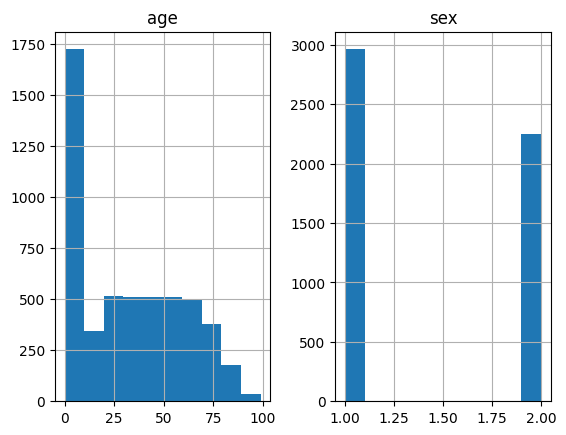

In [11]:
data.drop(['gs_text34'],1).hist()
plt.show()

(Explicacion)

In [12]:
data['gs_text34'].describe()

count                                        5209
unique                                         18
top       Pregnancy, childbirth and the puerperiu
freq                                          770
Name: gs_text34, dtype: object

(Explicacion)

<hr>

<h1>PreProcesamiento</h1>

Vamos a dividir el preprocesamiento en distintos pasos:

1.

2.

3.

4.

5.

6.

<h3>0. Traducir a español</h3>

In [32]:
data_esp = data.copy()

data_esp.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,94,95,96,97,98,99,tsne-one,tsne-two,tsne-three,gs_text34
0,0,-0.054230,-0.021399,-0.042359,0.073222,0.046764,-0.026668,0.004727,-0.010688,-0.083099,...,0.007643,0.019473,0.031546,0.013865,0.032571,-0.004009,-5.771113,1.901177,1.811722,Diseases of Respiratory System
1,1,-0.001660,-0.004658,-0.000319,0.002046,-0.002614,0.004619,-0.002384,-0.000557,0.001476,...,0.001213,-0.001499,0.002422,-0.002485,-0.000045,-0.000507,-5.768554,1.904271,1.813318,Diseases of Respiratory System
2,2,-0.000053,-0.000410,0.001628,0.004244,-0.003184,-0.002438,0.004294,-0.004996,0.003928,...,0.001497,0.003846,-0.001227,-0.000153,-0.002216,-0.003261,-5.773443,1.904981,1.815455,"Pregnancy, childbirth and the puerperiu"
3,3,-0.009391,-0.008851,-0.001480,0.016867,0.007397,0.003600,0.000947,-0.002355,-0.024652,...,0.001027,0.000408,0.003131,0.013499,0.010987,-0.008641,-5.775533,1.910413,1.811667,External Causes of Morbidity and Mortality
4,4,0.004680,-0.004014,-0.003003,0.000009,0.002985,0.002594,-0.004850,-0.001550,-0.003040,...,-0.000275,0.004279,0.003834,0.002462,0.001763,-0.003078,-5.775486,1.906089,1.814590,"Injury, Poisoning and External Causes"


In [114]:
from time import sleep
import concurrent.futures
import goslate

executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
gs = goslate.Goslate(service_urls=['http://translate.google.de'], executor=executor)

def traducir_ing2esp(txt):
    return gs.translate(txt, 'es') 

def traducir_esp2ing(txt):
    return gs.translate(txt, 'en') 

In [15]:
#data_esp["open_response"] = data_esp["open_response"].head(5).apply(lambda txt: traducir_ing2esp(txt))
#data_esp.head(5)


<h2>1. Pasar a minusculas el texto</h2>

(Explicacion)
CREO QUE YA ESTABA TODO EN MINUSCULAS

In [33]:
def to_minusculas(txt):
    return txt.lower()

In [17]:
data["open_response"] = data["open_response"].str.lower()
data.head(5)

#data_esp["open_response"] = data_esp["open_response"].str.lower()
#data_esp.head(5)

,module,age,sex,site,open_response,gs_text34
0,Adult,65.0,1,Bohol,date he felt a lower back pain and had fever s...,Diseases of Respiratory System
1,Child,0.0,2,Dar,the caese of death is pneumonia,Diseases of Respiratory System
2,Adult,23.0,2,AP,i took my wife to a private hospital for tubec...,"Pregnancy, childbirth and the puerperiu"
3,Adult,40.0,1,AP,he went to the work on sunday there were # iro...,External Causes of Morbidity and Mortality
4,Adult,55.0,1,UP,the deceased had died due to a snake bite the ...,"Injury, Poisoning and External Causes"


<h2>2. Quitar marcas de puntuacion</h2>

(Explicacion)

In [34]:
def quitar_marcasPuntuacion(text:str):
    return text.translate(str.maketrans('', '', string.punctuation))

In [19]:
print(data["open_response"][45])

my mother suffered from fever continuously for # months she was treated in hospital where the doctor prescribed medicines but fever did not control later she was taken to hospital since the treatment was so expensive in the hospital the doctor advised us to take her to hospital but we did not take her to hospital but took her to hospital and admitted there since stains were present all over the body the doctors were firm to see the test results on the stains to proceed further on treatment by that time they were not specific to name the disease she was dead when the treatment was going on


In [20]:
data["open_response"] = data["open_response"].apply(lambda txt: quitar_marcasPuntuacion(txt))

#data_esp["open_response"] = data_esp["open_response"].apply(lambda txt: quitar_marcasPuntuacion(txt))


In [21]:
print(data["open_response"][45])

my mother suffered from fever continuously for  months she was treated in hospital where the doctor prescribed medicines but fever did not control later she was taken to hospital since the treatment was so expensive in the hospital the doctor advised us to take her to hospital but we did not take her to hospital but took her to hospital and admitted there since stains were present all over the body the doctors were firm to see the test results on the stains to proceed further on treatment by that time they were not specific to name the disease she was dead when the treatment was going on


<h2>3. Extender las contracciones</h2>

In [35]:
def extender_contracciones(text):    
    expanded_words = []   
    for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  

    return ' '.join(expanded_words)

In [23]:
cntrtn_text = "I've to go the toilet, I can't wait."
print(cntrtn_text)
print(extender_contracciones(cntrtn_text))

I've to go the toilet, I can't wait.
I have to go the toilet, I cannot wait.


In [24]:
data["open_response"] = data["open_response"].apply(lambda txt: extender_contracciones(txt))

<h2>4. Stemming</h2>

In [25]:
#stemmer = PorterStemmer()

#def stem_palabras(text):
#    return " ".join([stemmer.stem(word) for word in text.split()])

In [26]:
#print(data["open_response"][0])

In [27]:
#data["open_response"] = data["open_response"].apply(lambda text: stem_palabras(text))

In [28]:
#print(data["open_response"][0])

<h2>5. Lematizacion</h2>

In [36]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

def lematizar_palabras(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /home/jfu08/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jfu08/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [30]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospital here in place the doctor was suspecting arthritis he was ordered for x ray so we went to hospital lab results are all normal but suddenly the complained of difficulty in breathing the doctor said that he has pneumonia oxygen inhalation was started and still he was weak and his blood sugar was elevated and he died the ff day


In [31]:
data["open_response"] = data["open_response"].apply(lambda text: lematizar_palabras(text))

In [32]:
print(data["open_response"][0])

date he felt a lower back pain and had fever so we went to hospital here in place the doctor wa suspecting arthritis he wa ordered for x ray so we went to hospital lab result are all normal but suddenly the complained of difficulty in breathing the doctor said that he ha pneumonia oxygen inhalation wa started and still he wa weak and his blood sugar wa elevated and he died the ff day


<h2>6. Quitar las stopwords</h2>

(Explicacion)

In [37]:
nltk.download('stopwords')
def quitar_stopwords(txt:str):
    return ' '.join([word for word in txt.split(' ') if word not in stopwords.words('english')])

[nltk_data] Downloading package stopwords to /home/jfu08/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
print(data["open_response"][1])

the caese of death is pneumonia


In [35]:
data["open_response"] = data["open_response"].apply(lambda txt: quitar_stopwords(txt))


In [36]:
print(data["open_response"][1])

caese death pneumonia


<h3>7. Quitar espacios extra</h3>

In [38]:
def quitar_espaciosExtra(txt:str):
    return re.sub(' +', ' ', txt)

In [38]:
xtrSpc_text = "I've   to  go the toilet,  I can't   wait."
print(xtrSpc_text)
print(quitar_espaciosExtra(xtrSpc_text))

I've   to  go the toilet,  I can't   wait.
I've to go the toilet, I can't wait.


In [39]:
data["open_response"] = data["open_response"].apply(lambda text: quitar_espaciosExtra(text))

#data_esp["open_response"] = data_esp["open_response"].apply(lambda text: quitar_espaciosExtra(text))

k-means eta document embedding, 

<h3>Guardar preproceso</h3>

In [40]:
data.to_csv('data_output/preproceso.csv')
#data_esp.to_csv('data_output/preproceso_esp.csv')

<hr>

<h2>Informacion sobre Data</h2>

<h3>Palablas mas usadas</h3>

In [41]:
from typing import Counter


cnt = Counter()

for text in data["open_response"].values:
    for word in text.split():
        cnt[word] += 1  

cnt.most_common(10)

[('wa', 16944),
 ('hospital', 7142),
 ('doctor', 4002),
 ('day', 3713),
 ('deceased', 3413),
 ('baby', 3239),
 ('died', 2885),
 ('said', 2436),
 ('year', 2320),
 ('also', 1918)]

<h3>WordCloud</h3>

/tmp/ipykernel_4879/1175978792.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mascara = imread('./images/maskHealth.png')


(-0.5, 511.5, 511.5, -0.5)

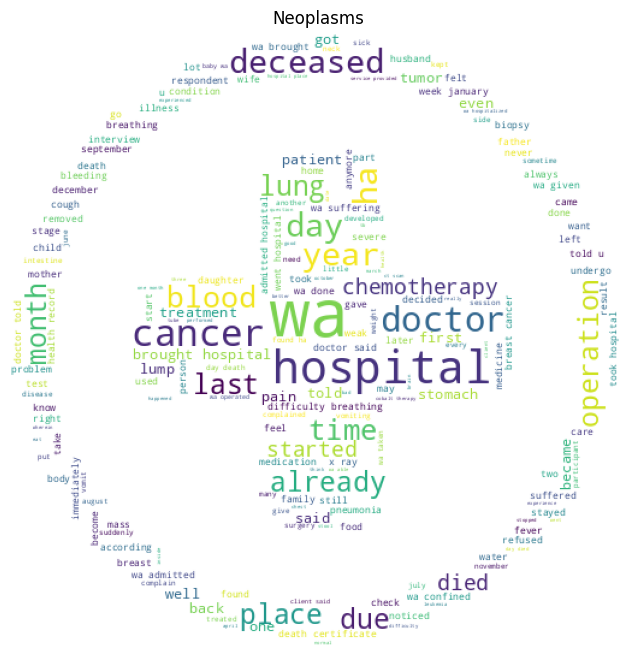

In [42]:
from wordcloud import WordCloud
from imageio import imread

neoplasms = data[data["gs_text34"]=="Neoplasms"]
neoplasms = neoplasms['open_response']

mascara = imread('./images/maskHealth.png')

neoplasmsWC = WordCloud(background_color='white',mask=mascara).generate(' '.join(neoplasms))
plt.figure(figsize=(11,8))
plt.imshow(neoplasmsWC)
plt.title("Neoplasms")
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

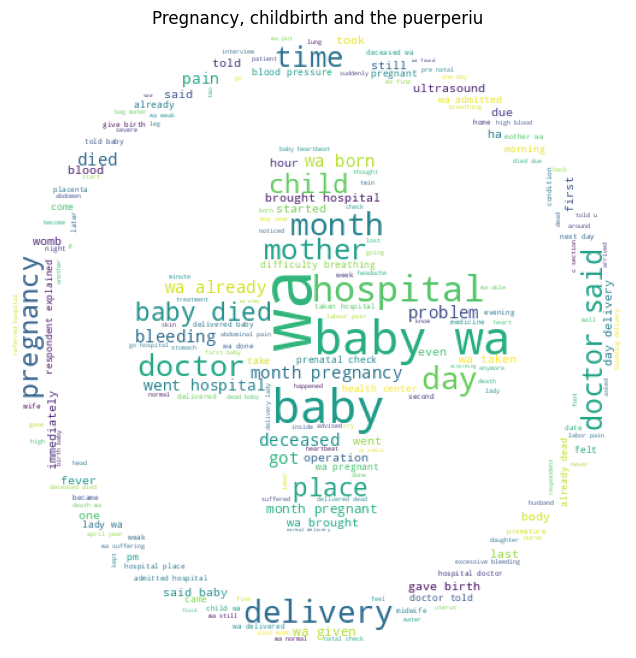

In [43]:
pcp = data[data["gs_text34"]=="Pregnancy, childbirth and the puerperiu"]
pcp = pcp['open_response']

pcpWC = WordCloud(background_color='white',mask=mascara).generate(' '.join(pcp))
plt.figure(figsize=(11,8))
plt.imshow(pcpWC)
plt.title("Pregnancy, childbirth and the puerperiu")
plt.axis("off")

<hr>

<h2>Document embeding</h2>

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


try: data
except NameError: data = pd.read_csv("data_output/preproceso.csv")

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(data['open_response'])]

In [10]:
model = Doc2Vec(vector_size=100, min_count=2, epochs=10) #crear el modelo
model.build_vocab(tagged_data) #crear el diccionario del modelo a partir del atributo 'open_response' de nuestras instancias
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs) #entrenar el modelo

In [11]:
model.save("model/doc2vec.model") #guardar el modelo para no tener que entrenarlo en cada ejecución


In [35]:
tagged_df = pd.Series( (v[0] for v in tagged_data))
data_de = pd.DataFrame(columns=list(range(100)), index=list(range(len(data))))

for i in range(data.shape[0]):
    data_de.loc[i] = model.infer_vector(tagged_df[i].split(" "))

data_de.to_csv('data_output/doc_embeding.csv')


<hr>

<h2>Representacion grafica</h2>

<h3>TSNE</h3>

In [14]:
from sklearn.manifold import TSNE

#try: data
#except NameError: data = pd.read_csv("data_output/doc_embeding.csv")

data = pd.read_csv("data_output/doc_embeding.csv")

tsne = TSNE(n_components=3, verbose=1, perplexity=20, n_iter=250)
tsne_results = tsne.fit_transform(data)
tsne_results

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5209 samples in 0.000s...
[t-SNE] Computed neighbors for 5209 samples in 0.449s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5209
[t-SNE] Computed conditional probabilities for sample 2000 / 5209
[t-SNE] Computed conditional probabilities for sample 3000 / 5209
[t-SNE] Computed conditional probabilities for sample 4000 / 5209
[t-SNE] Computed conditional probabilities for sample 5000 / 5209
[t-SNE] Computed conditional probabilities for sample 5209 / 5209
[t-SNE] Mean sigma: 7.128120
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.250389
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00

array([[-2.9916945,  4.2885447,  3.3769863],
       [-2.992215 ,  4.2893095,  3.3772478],
       [-2.9904146,  4.288432 ,  3.3761322],
       ...,
       [ 1.5923012, -4.216706 , -4.106087 ],
       [ 1.5887271, -4.213929 , -4.105433 ],
       [ 1.5895205, -4.21588  , -4.102372 ]], dtype=float32)

In [15]:
label = pd.read_csv("data_output/preproceso.csv")
label = label['gs_text34']

data['tsne-one'] = tsne_results[:,0]
data['tsne-two'] = tsne_results[:,1]
data['tsne-three'] = tsne_results[:,2]
data['gs_text34'] = label
data_tsn = data.filter(['tsne-one', 'tsne-two','tsne-three','gs_text34'])
data_tsn.to_csv('data_graphics/data_tsne.csv')
data_tsn

,tsne-one,tsne-two,tsne-three,gs_text34
0,-2.991694,4.288545,3.376986,Diseases of Respiratory System
1,-2.992215,4.289310,3.377248,Diseases of Respiratory System
2,-2.990415,4.288432,3.376132,"Pregnancy, childbirth and the puerperiu"
3,-2.992430,4.293755,3.377234,External Causes of Morbidity and Mortality
4,-2.989641,4.288625,3.377295,"Injury, Poisoning and External Causes"
...,...,...,...,...
5204,1.589375,-4.214855,-4.106235,"Endocrine, Nutritional and Metabolic Diseases"
5205,1.589281,-4.215004,-4.105125,Other Infectious Diseases
5206,1.592301,-4.216706,-4.106087,Diseases of Respiratory System
5207,1.588727,-4.213929,-4.105433,Other Cardiovascular Diseases


In [16]:
import plotly.express as px

pca_3d = px.scatter_3d(data_tsn, x='tsne-one', y='tsne-two', z='tsne-three', color='gs_text34')
pca_3d.show()

<h3>PCA</h3>

https://builtin.com/data-science/tsne-python

In [13]:
from sklearn.decomposition import PCA

data = pd.read_csv("data_output/doc_embeding.csv")

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data)
pca_result

array([[-2.60400000e+03,  4.48981951e-01,  6.89074075e-02],
       [-2.60300000e+03, -5.59270919e-02,  4.78067381e-03],
       [-2.60200000e+03, -6.13186794e-02,  5.02267141e-03],
       ...,
       [ 2.60200000e+03, -6.22602402e-02,  7.06110160e-03],
       [ 2.60300000e+03, -6.73645595e-02,  6.69557666e-03],
       [ 2.60400000e+03, -6.52544752e-02,  3.08852342e-03]])

In [ ]:
label = pd.read_csv("data_output/preproceso.csv")
label = label['gs_text34']

data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1]
data['pca-three'] = pca_result[:,2]
data['gs_text34'] = label

data_pca = data.filter(['pca-one', 'pca-two','pca-three','gs_text34'])
data_pca.to_csv('data_graphics/data_pca.csv')

data_pca

,pca-one,pca-two,pca-three,gs_text34
0,-2603.999999,0.467211,0.068644,Diseases of Respiratory System
1,-2603.000000,-0.063272,0.006980,Diseases of Respiratory System
2,-2602.000000,-0.062195,0.006135,"Pregnancy, childbirth and the puerperiu"
3,-2601.000000,0.034048,-0.014687,External Causes of Morbidity and Mortality
4,-2600.000000,-0.055643,0.004091,"Injury, Poisoning and External Causes"
...,...,...,...,...
5204,2600.000000,-0.066797,0.009768,"Endocrine, Nutritional and Metabolic Diseases"
5205,2601.000000,-0.068244,0.007501,Other Infectious Diseases
5206,2602.000000,-0.066063,0.008268,Diseases of Respiratory System
5207,2603.000000,-0.062586,0.005207,Other Cardiovascular Diseases


In [ ]:
pca_3d = px.scatter_3d(data_pca, x='pca-one', y='pca-two', z='pca-three', color='gs_text34')
pca_3d.show()


<h3>TSNE - PCA50</h3>

In [ ]:
data = pd.read_csv("data_output/doc_embeding.csv")

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data)

In [ ]:
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
tsne_pca_results

/home/peio/anaconda3/envs/md/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/peio/anaconda3/envs/md/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



array([[-5.4185987 ,  5.83472   , -6.1588054 ],
       [-5.41114   ,  5.831033  , -6.1588583 ],
       [-5.403309  ,  5.827159  , -6.1589    ],
       ...,
       [ 1.3299383 ,  8.957638  ,  0.17567211],
       [ 1.3261397 ,  8.966057  ,  0.17652948],
       [ 1.3225044 ,  8.974076  ,  0.17734623]], dtype=float32)

In [ ]:
label = pd.read_csv("data_output/preproceso.csv")
label = label['gs_text34']

data['tsne-pca50-one'] = tsne_pca_results[:,0]
data['tsne-pca50-two'] = tsne_pca_results[:,1]
data['tsne-pca50-three'] = tsne_pca_results[:,2]
data['gs_text34'] = label

data_tsne_pca = data.filter(['tsne-pca50-one', 'tsne-pca50-two','tsne-pca50-three','gs_text34'])
data_tsne_pca.to_csv('data_graphics/data_tsne_pca.csv')

data_tsne_pca

,tsne-pca50-one,tsne-pca50-two,tsne-pca50-three,gs_text34
0,-5.418599,5.834720,-6.158805,Diseases of Respiratory System
1,-5.411140,5.831033,-6.158858,Diseases of Respiratory System
2,-5.403309,5.827159,-6.158900,"Pregnancy, childbirth and the puerperiu"
3,-5.395133,5.823121,-6.158950,External Causes of Morbidity and Mortality
4,-5.386448,5.818781,-6.159007,"Injury, Poisoning and External Causes"
...,...,...,...,...
5204,1.338063,8.939382,0.173862,"Endocrine, Nutritional and Metabolic Diseases"
5205,1.333899,8.948742,0.174779,Other Infectious Diseases
5206,1.329938,8.957638,0.175672,Diseases of Respiratory System
5207,1.326140,8.966057,0.176529,Other Cardiovascular Diseases


In [ ]:
tsne_pca_3d = px.scatter_3d(data_tsne_pca, x='tsne-pca50-one', y='tsne-pca50-two', z='tsne-pca50-three', color='gs_text34')
tsne_pca_3d.show()

<h3>Comparacion 2D</h3>

<AxesSubplot: xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

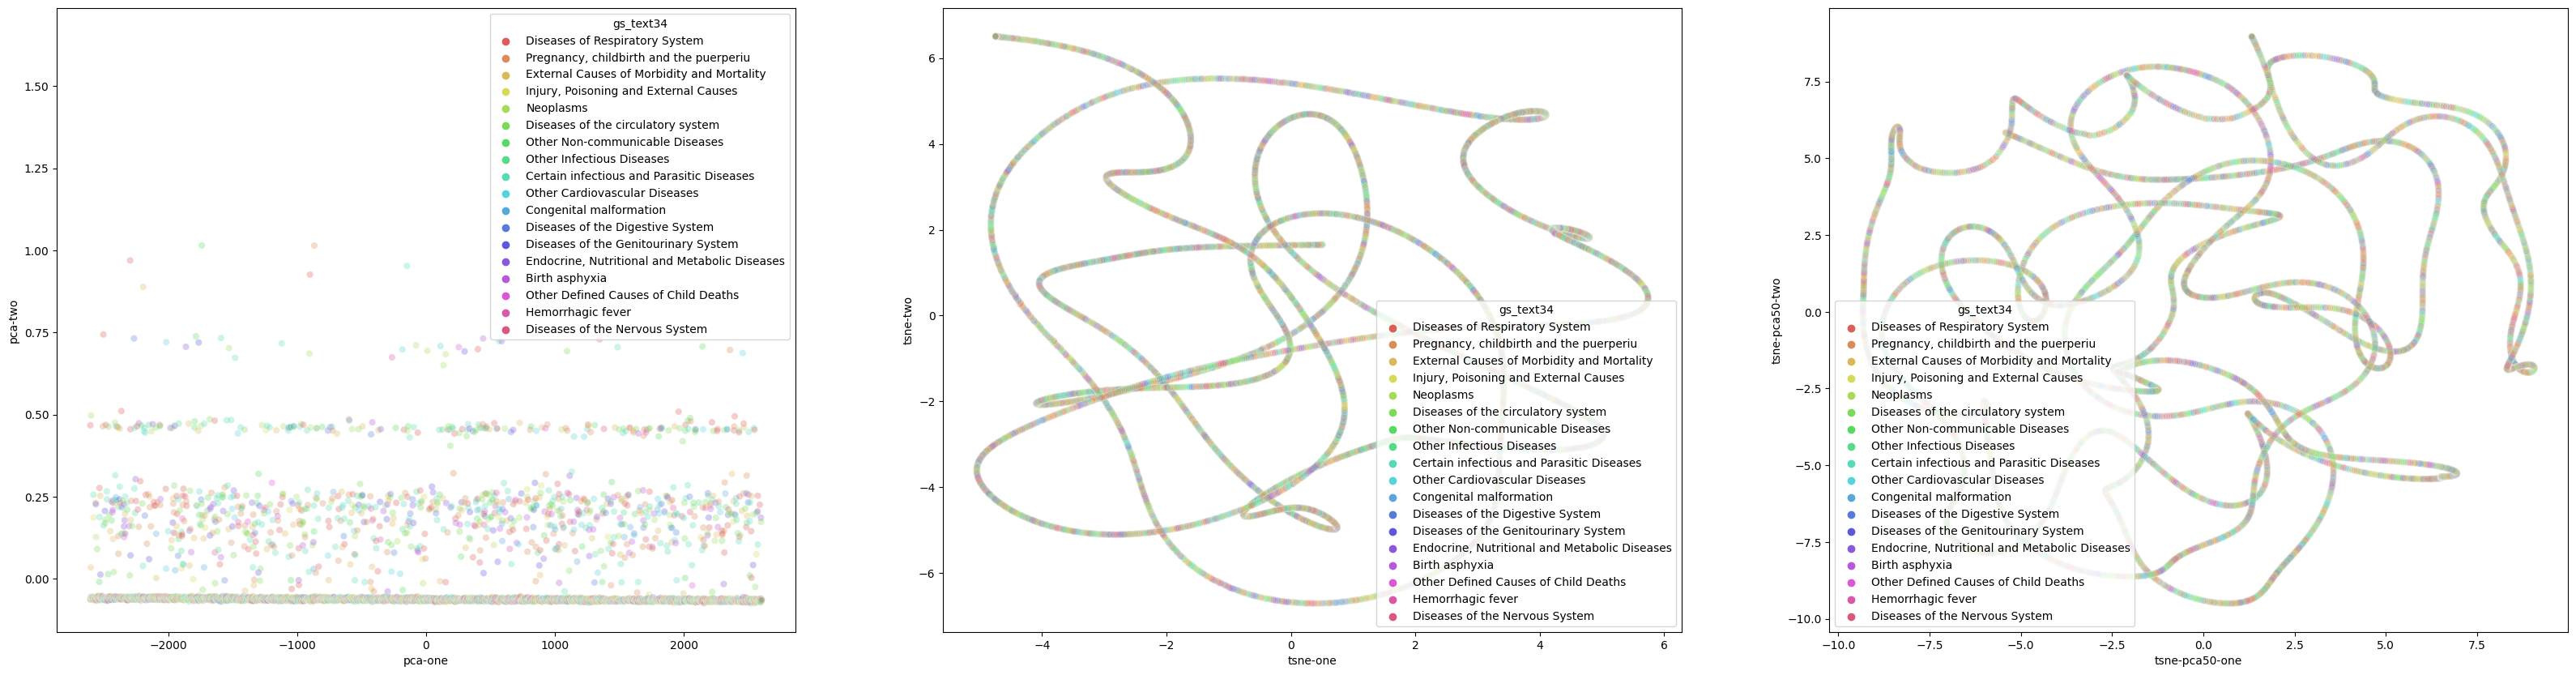

In [ ]:
import seaborn as sns

plt.figure(figsize=(40,10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 1)
ax3 = plt.subplot(1, 3, 1)

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 18),
    data=data_pca,
    legend="full",
    alpha=0.3,
    ax=ax1
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 18),
    data=data_tsn,
    legend="full",
    alpha=0.3,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 18),
    data=data_tsne_pca,
    legend="full",
    alpha=0.3,
    ax=ax3
)

<hr>

<h2>Conseguir el numero optimo de clusters</h2>

<h3>Metodo Elbow-index (distorsion e inercia)</h3>

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

def elbow_index(X):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 50)

    for k in K:
        # Building and fitting the model
        print('K: ' + str(k))
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
    
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])
        inertias.append(kmeanModel.inertia_)
    
        mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0]
        mapping2[k] = kmeanModel.inertia_
    
    return mapping1, mapping2, distortions, inertias

In [ ]:
import pandas as pd

data = pd.read_csv('data_output/doc_embeding.csv')
data = data.iloc[:,1:]
mapping1, mapping2, distortions, inertias = elbow_index(data)

K: 1
K: 2
K: 3
K: 4
K: 5
K: 6
K: 7
K: 8
K: 9
K: 10
K: 11
K: 12
K: 13
K: 14
K: 15
K: 16
K: 17
K: 18
K: 19
K: 20
K: 21
K: 22
K: 23
K: 24
K: 25
K: 26
K: 27
K: 28
K: 29
K: 30
K: 31
K: 32
K: 33
K: 34
K: 35
K: 36
K: 37
K: 38
K: 39
K: 40
K: 41
K: 42
K: 43
K: 44
K: 45
K: 46
K: 47
K: 48
K: 49


<h4>Distorsion</h4>

In [ ]:
f = open('data_output/distortions.txt', 'w')
for key, val in mapping1.items():
    print(f'{key} : {val}')
    f.write(f'{key} : {val}' + '\n') 

f.close()

1 : 0.10705590002044008
2 : 0.0526558062848379
3 : 0.040807915068377526
4 : 0.0389445236664289
5 : 0.03675138447705079
6 : 0.036351465415999144
7 : 0.03560924021637047
8 : 0.03494144630825866
9 : 0.03466930880539534
10 : 0.03428619068859685
11 : 0.0339747224414519
12 : 0.03393196094701342
13 : 0.03358280614713464
14 : 0.03338157951604604
15 : 0.03331090123446014
16 : 0.03327751482701041
17 : 0.03294820464139402
18 : 0.032839287545153285
19 : 0.032768253383883825
20 : 0.03273267647983583
21 : 0.03268510462244338
22 : 0.03255463699259294
23 : 0.03254971338794916
24 : 0.032472537806145854
25 : 0.0324789686481144
26 : 0.03235695889572801
27 : 0.03232108132350504
28 : 0.03226141174016104
29 : 0.03219744244234231
30 : 0.03209579393920324
31 : 0.032067557563818246
32 : 0.03204986790761709
33 : 0.032045502237087485
34 : 0.031958950954964496
35 : 0.03188456753227517
36 : 0.0318695749407599
37 : 0.031847156358877374
38 : 0.03177831695330072
39 : 0.0317131693894584
40 : 0.0317024439892458
41 : 0.

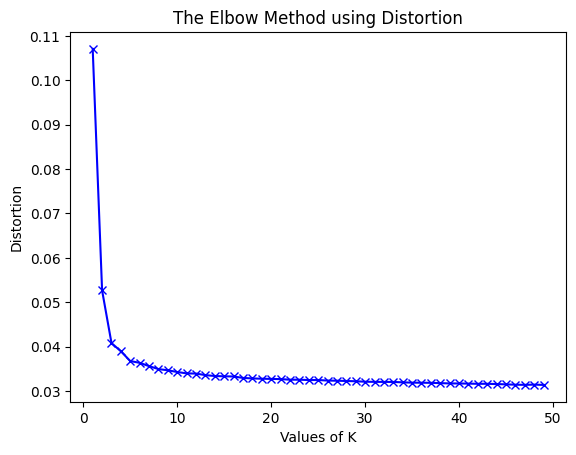

In [ ]:
K = range(1, 50)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

<h4>Inercia</h4>

In [ ]:
f = open('data_output/inertias.txt', 'w')
for key, val in mapping2.items():
    print(f'{key} : {val}')
    f.write(f'{key} : {val}' + '\n') 

f.close()

1 : 119.28528506229384
2 : 36.01761431634072
3 : 16.264603162342134
4 : 12.506427744274477
5 : 10.60024690261818
6 : 9.247168943828198
7 : 8.569530771984416
8 : 8.021077980863614
9 : 7.635337805487033
10 : 7.39896377199034
11 : 7.110509457700381
12 : 7.059607470987668
13 : 6.869819520952222
14 : 6.710544260826082
15 : 6.643880140197664
16 : 6.640452317428576
17 : 6.456564355405842
18 : 6.435951888833539
19 : 6.339116973632323
20 : 6.348161880109382
21 : 6.301839362637548
22 : 6.254153134854789
23 : 6.218256299563115
24 : 6.143023570001197
25 : 6.175167754580267
26 : 6.111014769822322
27 : 6.081211396728294
28 : 6.026063777834068
29 : 5.986233791505758
30 : 5.9442322980709426
31 : 5.943040918385313
32 : 5.929232546583463
33 : 5.875216101771262
34 : 5.863156823452096
35 : 5.834586236047465
36 : 5.784565229113994
37 : 5.763134220200564
38 : 5.7706291042674245
39 : 5.662089604196516
40 : 5.683261472561024
41 : 5.690520525004955
42 : 5.653244080428095
43 : 5.650161048408218
44 : 5.596707850

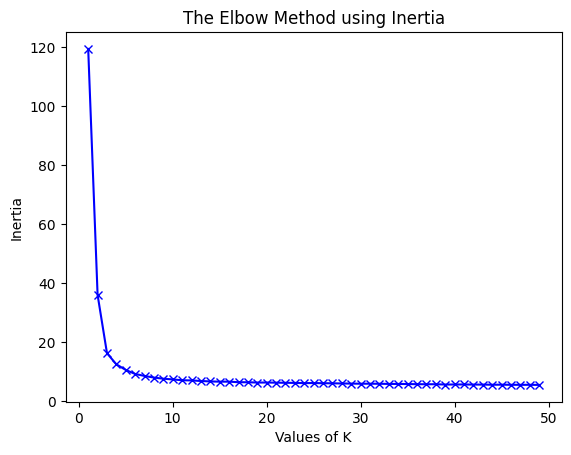

In [ ]:
K = range(1, 50)

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

<hr>

<h2>K-Means Clustering</h2>

<h3>Funciones auxiliares para el kmeans</h3>

In [38]:
import math
def dist_minkowski(inst1, inst2, alpha):
    # inst1 = (x1, ..., xi, ... xn)
    # inst2 = (z1, ..., zi, ... zn) 
    distancia = 0
    for i in range(len(inst1.columns)): # las 2 instancias tienen la misma longitud
        distancia += pow(abs(inst2.iloc[0, i] - inst1.iloc[0, i]), alpha)
    distancia = pow(distancia, 1 / alpha)
    return distancia

In [39]:
def media(cluster):
    # inicializar lista para luego hacer la media en cada atributo
    #print(cluster)
    lista_atr_centroide = pd.DataFrame(0, index = range(1), columns = range(len(cluster.columns)))
        
    # Suma de todos los valores de cada atributo (cada elemento del array corresponde a un atributo)    
    for i in range(len(cluster)): # Por cada fila (0 <= i < x)
        for j in range(len(cluster.columns)): # Por cada columna (0 <= j < 100)
            lista_atr_centroide.iloc[0, j] += cluster.iloc[i, j]

    
    # Suma de los valores entre la cantidad de instancias (MEDIA)
    for k in range(len(lista_atr_centroide.columns)):
        lista_atr_centroide.iloc[0, k] /= len(cluster)
    return lista_atr_centroide

In [40]:
def single_link(cluster1, cluster2, alpha): 
    min = -1 #valor por defecto para decir que todavía no tiene ningún valor
    for i in range(len(cluster1)):
        for j in range(len(cluster2)):
            dist_actual = dist_minkowski(cluster1.iloc[[i]], cluster2.iloc[[j]], alpha)
            print("distancia entre: " + str(cluster1.iloc[[i]]) + " " + str(cluster2.iloc[[j]]) + " = " + str(dist_actual))
            if min == -1:
                min = dist_actual
            else:
                if dist_actual < min:
                    min = dist_actual
    return min

In [41]:
def complete_link(cluster1, cluster2, alpha):    
    max = -1 #valor por defecto para decir que todavía no tiene ningún valor
    for i in range(len(cluster1)):
        for j in range(len(cluster2)):
            dist_actual = dist_minkowski(cluster1.iloc[[i]], cluster2.iloc[[j]], alpha)
            print("distancia entre: " + str(cluster1.iloc[[i]]) + " " + str(cluster2.iloc[[j]]) + " = " + str(dist_actual))
            if max == -1:
                max = dist_actual
            else:
                if dist_actual > max:
                    max = dist_actual
    return max 

In [42]:
def silhouette_una_instancia(inst_ind, instancia, clusters, alpha):
    # Averigua a qué cluster pertenece la instancia
    g_j_ind = pd.read_csv('data_output/asignacion_instancia_cluster.csv').iloc[inst_ind, 1] # g_j = {0, 1, 2}
    g_j = clusters[g_j_ind]
    
    # Calcular la distancia media entre la instancia y las instancias del cluster g_j
    distancia_a = 0
    for i in range(len(g_j)):
        distancia_a += dist_minkowski(instancia, g_j.iloc[[i]], alpha)
        # print("Distancia actual (a) = " + str(distancia_a))    
    if len(g_j) == 1: # El cluster está compuesto sólo por 'intancia'
        a_xi = 0
    else:
        a_xi = 1 / (len(g_j) - 1) * distancia_a

    # Calcular la mínima distancia media entre la instancia y las intancias de los otros clusters
    b_xi = float('inf')
    for cl_ind in range(len(clusters)):
        if cl_ind != g_j_ind and len(clusters[cl_ind]) != 0: # Sólo se miran los otros clusters que no están vacíos
            distancia_b_actual = 0
            for i in range(len(clusters[cl_ind])):
                distancia_b_actual += dist_minkowski(instancia, clusters[cl_ind].iloc[[i]], alpha)
                # print("Distancia actual (b) = " + str(distancia_b_actual))
            b_xi_actual = 1 / (len(clusters[cl_ind])) * distancia_b_actual
            if b_xi_actual < b_xi:
                b_xi = b_xi_actual      

    # Calcular valor del índice de evaluación interna 'Silueta'
    silhouette = (b_xi - a_xi) / max(b_xi, a_xi)
    return silhouette

In [43]:
def inic_aleatoria(datos, num_centroides):
    centroides = datos.sample(n = num_centroides)
    return centroides

In [53]:
def inic_2k_clusters(k, alpha):

    # k = 3 # luego se pasa como parámetro al clustering
    # # Cargar los datos
    # datos_kmeans = pd.read_csv('data_output/doc_embeding.csv')
    # datos_kmeans = datos_kmeans.iloc[:20, 1:]

    #### Inicialización de centroides (Modo 3: 2k clusters --> elegir k centroides más alejados entre sí)

    ## Crear 2k clusters
    num_clusters = 2 * k # 4 clusters
    num_instancias = len(datos_kmeans) # 20 instancias
    tamaño_cluster = num_instancias // num_clusters # 5intancias / cluster
    instancias_restantes = num_instancias % num_clusters # algunos cluster van a ser más grandes si no podemos hacer todos del mismo tamaño
    clusters = []

    print("Número de clusters: " + str(num_clusters))
    print("Número de instancias: " + str(num_instancias))
    print("Tamaño de mínimo de cada cluster: " + str(tamaño_cluster))
    print()

    ind_principio = 0
    ind_final = -1
    for i in range(num_clusters):
        tamaño_def_cluster = tamaño_cluster
        if instancias_restantes > 0:
            tamaño_def_cluster += 1
            instancias_restantes -= 1
        #cluster = datos_kmeans.iloc[tamaño_def_cluster * i:tamaño_def_cluster  * (i + 1)]
        ind_final = ind_principio + tamaño_def_cluster
        cluster = datos_kmeans.iloc[ind_principio:ind_final]
        clusters.append(cluster)
        ind_principio = ind_final
    #print(clusters)

    ## Elegir k centroides más alejados entre sí

    # Calcular los centroides de los cluster que se han creado
    centroides = pd.concat([media(cluster) for cluster in clusters], ignore_index=True)
    #print(centroides)

    # Calcular las distancias medias entre centroides
    dict_dist_cent = {}
    for cent_ind_1 in range(len(centroides)):
        suma_distancias = 0
        for cent_ind_2 in range(len(centroides)):
            cent_1 = centroides.iloc[[cent_ind_1]]
            cent_2 = centroides.iloc[[cent_ind_2]]
            distancia_actual = dist_minkowski(cent_1, cent_2, alpha)
            # print(f"Distancia entre centroide {cent_ind_1} y centroide {cent_ind_2}: {distancia_actual}")
            suma_distancias += distancia_actual
        distancia_media = suma_distancias / len(centroides)
        dict_dist_cent[cent_ind_1] = distancia_media
        #print(f"Distancia media para el centroide {cent_ind_1}: {distancia_media}")
        #print()

    # Ordenar centroides por distancias medias (más alejado - más cercano) [k centroides más lejanos]
    indices_centroides_mas_lejanos = sorted(dict_dist_cent, key=dict_dist_cent.get, reverse=True)[:k] # pone que hay que elegirlo con un parámetro
    #print(indices_centroides_mas_lejanos)

    # Guardar centroides más alejados entre sí
    centroides_mas_lejanos = pd.concat([centroides.iloc[[cent_ind_cercano]] for cent_ind_cercano in indices_centroides_mas_lejanos])
    #print(centroides_mas_lejanos)

    return centroides_mas_lejanos

<h3>Función para hacer el k-means</h3>

<h4>Cargar los datos</h4>

In [45]:
datos_kmeans = pd.read_csv('data_output/doc_embeding.csv')
datos_kmeans = datos_kmeans.iloc[:20, 1:]
print(datos_kmeans)

           0         1         2         3         4         5         6  \
0  -0.054230 -0.021399 -0.042359  0.073222  0.046764 -0.026668  0.004727   
1  -0.001660 -0.004658 -0.000319  0.002046 -0.002614  0.004619 -0.002384   
2  -0.000053 -0.000410  0.001628  0.004244 -0.003184 -0.002438  0.004294   
3  -0.009391 -0.008851 -0.001480  0.016867  0.007397  0.003600  0.000947   
4   0.004680 -0.004014 -0.003003  0.000009  0.002985  0.002594 -0.004850   
5  -0.002968  0.004956  0.002286 -0.001720 -0.003219  0.002060 -0.000854   
6  -0.033894 -0.024448 -0.028619  0.092705  0.045513 -0.019659  0.014415   
7  -0.002697 -0.000535  0.003095  0.000474 -0.003777 -0.000915  0.001201   
8   0.001165  0.002247 -0.003192 -0.001354 -0.001100  0.003119  0.000613   
9   0.002584 -0.000172 -0.003631 -0.004477  0.003447  0.002698  0.004991   
10 -0.003720  0.002464  0.002986  0.003859 -0.001756  0.000653  0.003629   
11  0.001782 -0.000217  0.002726  0.003517  0.000313 -0.004699 -0.002087   
12  0.004415

<h4>Implementación de k-means (sin librerías)</h4>

In [54]:
def kmeans_clustering(modo_inic_datos, alpha, int_grup_dist_func, num_iter, num_centroides, datos):

    ## Inicialización de centroides
    if modo_inic_datos == 0: #Inicializar centroides aleatoriamente
        #entroides = datos.sample(n = num_centroides)
        centroides = inic_aleatoria(datos, num_centroides)
    elif modo_inic_datos == 1:
        centroides = inic_2k_clusters(num_centroides, alpha)

    centroides_con_indice = []
    for i in range(num_centroides):
        centroides_con_indice.append( (centroides.iloc[[i]], i + 1) )        
    
    # Para guardar las instancias de cada cluster
    clusters = []
    for i in range(len(centroides)):
        clusters.append(pd.DataFrame())

    # Para guardar la correspondencia instancia-cluster
    asignacion_instancia_cluster = pd.DataFrame(index = list(range(len(datos))), columns = ['cluster', 'instancia'])
    open_response = pd.read_csv("data_output/preproceso.csv")['open_response']
    #open_response = data[0:10]


    ## Definir criterio de convergencia (de momento sólo con 'num_iter')
    for iteracion in range(num_iter):
        #print(f"\nIteración nº {iteracion + 1}")

        # Cálculo de distancias entre instancias y centroides.
        # A cada instancia se le asigna el cluster cuyo centroide esté más cerca (alpha = 3)
        for i in range(len(datos)): # por cada frase = [0,02038866, 0.00355687, ...]
            dato = datos.iloc[[i]]
            dist_inst_cent_min = -1 # valor por defecto para decir que todavía no tiene ningún valor
            centroide_min_ind = -1
        
            # Cálculo entre una instancia y todos centroides --> distMin, cluster
            for centroide in centroides_con_indice:
                valores_centroide = centroide[0]
                indice_centroide = centroide[1]   

                if not valores_centroide.empty: # Para evitar problemas en caso de que haya un cluster vacío
                    dist_inst_cent = dist_minkowski(dato, valores_centroide, 3)
                    if dist_inst_cent_min == -1:
                        dist_inst_cent_min = dist_inst_cent
                        centroide_min_ind = centroide[1]
                    else:
                        if dist_inst_cent < dist_inst_cent_min:
                            dist_inst_cent_min = dist_inst_cent
                            centroide_min_ind = centroide[1]

            # Asignar un cluster a una instancia según la cercanía con los centroides
            frames = [clusters[centroide_min_ind - 1], dato]
            clusters[centroide_min_ind - 1] = pd.concat(frames)
            
            asignacion_instancia_cluster.iloc[i, 0] = centroide_min_ind - 1
            asignacion_instancia_cluster.iloc[i, 1] = open_response.iloc[i]
            ####print(f"Instancia {i} --> Cluster = {asignacion_instancia_cluster.iloc[i, 0]}")


        for i in range(len(clusters)):
            cluster = clusters[i]
            #print("Cluster" + str(i) + ": " + str(len(cluster)) + str(cluster))

        ## Mostrar clusters hasta el momento mediante representación PCA (2D)
        data = pd.read_csv("data_output/doc_embeding.csv").iloc[:10, 1:]
        pca = PCA(n_components = 2)
        pca_2d_result = pca.fit_transform(data)
        cluster_ind = pd.read_csv("data_output/asignacion_instancia_cluster.csv")
        cluster_ind = cluster_ind['cluster']
        for i in range(len(cluster_ind)):
            cluster_ind.loc[i] = f"Cluster {cluster_ind.loc[i]}"

        data['atr_más_relevante1'] = pca_2d_result[:,0]
        data['atr_más_relevante2'] = pca_2d_result[:,1]
        data['cluster_ind'] = cluster_ind

        data_pca_2d = data.filter(['atr_más_relevante1', 'atr_más_relevante2', 'cluster_ind'])
        pca_2d = px.scatter(data_pca_2d, x='atr_más_relevante1', y='atr_más_relevante2', color='cluster_ind', title=f"\nIteración nº {iteracion + 1}")
        pca_2d.show()
            
        ## Recálcular los centroides
        centroides_con_indice.clear() # se borran los centroides de antes
        for i in range(num_centroides):
            centroide_i = media(clusters[i])
            centroides_con_indice.append( (centroide_i, i + 1) )

        if iteracion != num_iter - 1:
            for i in range(num_centroides):
                clusters[i] = pd.DataFrame()

    ## Resultados
    ####print()
    ####print(clusters)

    # Coordenadas de los centroides
    centroides_definitivos_df = pd.concat([centroides_con_indice[i][0] for i in range(len(centroides_con_indice))], ignore_index=True)
    ####print(centroides_definitivos_df)
    centroides_definitivos_df.to_csv("data_output/centroides_kmeans.csv")

    # Asignacion de las instancias a los clusters
    ####print("\n")
    for i in range(len(clusters)):
        clusters[i].to_csv(f"data_cluster/cluster{i}.csv")
    ####print(asignacion_instancia_cluster)
    asignacion_instancia_cluster.to_csv("data_output/asignacion_instancia_cluster.csv")

    # Indicadores internos de la calidad del resultado
    # Calcular valor de siluetas en caso de estar en la última iteración
    silhouettes = []
    print("\nVALORES SILUETAS:")
    for i in range(len(datos)):
        dato = datos.iloc[[i]]
        s = silhouette_una_instancia(i, dato, clusters, alpha)
        ####print(f"Silueta (instancia {i}) = {s}")
        silhouettes.append(s)
    ####print("\n")
    ####print(silhouettes)
    silhouette_media = sum(silhouettes) / len(silhouettes)
    print("Silueta media = " + str(silhouette_media))
    return silhouette_media, silhouettes

<h3>Prueba del k-means con distintos valores para obtener k óptima</h3>

k-means clustering (k = 2)

Número de clusters: 4
Número de instancias: 20
Tamaño de mínimo de cada cluster: 5




VALORES SILUETAS:
Silueta media = 0.8862028457288529
k-means clustering (k = 3)

Número de clusters: 6
Número de instancias: 20
Tamaño de mínimo de cada cluster: 3




VALORES SILUETAS:
Silueta media = 0.8862028457288529
k-means clustering (k = 4)

Número de clusters: 8
Número de instancias: 20
Tamaño de mínimo de cada cluster: 2




VALORES SILUETAS:
Silueta media = 0.8862028457288529
k-means clustering (k = 5)

Número de clusters: 10
Número de instancias: 20
Tamaño de mínimo de cada cluster: 2




VALORES SILUETAS:
Silueta media = 0.16772760694407504


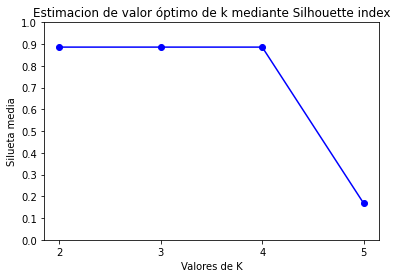

In [55]:
dict_k_sil = {}
valores_k = list(range(2, 6))
for k in valores_k:
    print(f"k-means clustering (k = {k})\n")
    # def kmeans_clustering(modo_inic_datos, alpha, int_grup_dist_func, num_iter, num_centroides, datos):
    sil_media, siluetas = kmeans_clustering(1, 3, 0, 3, k, datos_kmeans)
    dict_k_sil[k] = sil_media  

# # # # print("\n\n")
# # # # for key, value in dict_k_sil.items():
# # # #     print(f"Silueta media (k = {key}): {value}")

# Mostrar relación entre valor de k y media de la silueta de las instancias gráficamente
plt.plot(dict_k_sil.keys(), dict_k_sil.values(), 'bo-')
plt.xlabel('Valores de K')
plt.xticks(list(dict_k_sil.keys()))
plt.ylabel('Silueta media')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Estimacion de valor óptimo de k mediante Silhouette index')
plt.show()

<hr>

<h2>Asignar clase mayoritaria a los cluster obtenidos en k-Means</h2>

In [101]:
def asignar_clase2cluster(pathCluster, pathData):
    
    data_cluster = pd.read_csv(pathCluster)
    #data_cluster = data_cluster.iloc[:,1:]
    data = pd.read_csv(pathData)

    claseMayoritaria = ''
    clases = {}

    for instance in data_cluster.iterrows():
        indexInstance = instance[1][0]
        clase = data.iloc[[indexInstance]]
        clase = clase['gs_text34'].iat[0]

        if clase not in clases:
            clases[clase] = 0
        else:
            clases[clase] += 1
    
    claseMayoritaria = max(clases, key=clases.get)

    return claseMayoritaria

In [106]:
def asignar_clusters(nClusters):

    df = pd.DataFrame(index=range(nClusters),columns=range(2))

    pathOriginal = 'data_output/preproceso.csv'

    for i in range(0,nClusters):

        path = "data_cluster/cluster" + str(i) + ".csv"

        clase = asignar_clase2cluster(path, pathOriginal)

        df.iloc[i] = [i,clase]

        print(str(i) + ' :' + str(clase))

    df.to_csv('data_output/clusters.csv')

In [107]:
asignar_clusters(3)

0 :Other Non-communicable Diseases
1 :Diseases of Respiratory System
2 :Pregnancy, childbirth and the puerperiu


In [108]:
pathOriginal = 'data_output/preproceso.csv'
data = pd.read_csv(pathOriginal)
data.head(10)

,Unnamed: 0,module,age,sex,site,open_response,gs_text34
0,0,Adult,65.0,1,Bohol,date felt lower back pain fever went hospital ...,Diseases of Respiratory System
1,1,Child,0.0,2,Dar,caese death pneumonia,Diseases of Respiratory System
2,2,Adult,23.0,2,AP,took wife private hospital tubectomy time wa p...,"Pregnancy, childbirth and the puerperiu"
3,3,Adult,40.0,1,AP,went work sunday iron rod brother person went ...,External Causes of Morbidity and Mortality
4,4,Adult,55.0,1,UP,deceased died due snake bite deceased regained...,"Injury, Poisoning and External Causes"
5,5,Neonate,0.0,1,Bohol,june year respondent experienced pain upper po...,"Pregnancy, childbirth and the puerperiu"
6,6,Child,4.0,2,AP,consult doctor saw patient said wa critical co...,Neoplasms
7,7,Adult,73.0,1,UP,deceased suffering coughing since month death ...,Diseases of the circulatory system
8,8,Adult,54.0,2,Bohol,wa admitted hospital wa found ha toxic goiter ...,Other Non-communicable Diseases
9,9,Adult,15.0,2,UP,deceased ill year treatment wa ongoing private...,Other Infectious Diseases


<hr>

<h2>Representacion post-kmeans</h2>

<h3>Representacion grafica</h3>

In [6]:
from sklearn.manifold import TSNE

#try: data
#except NameError: data = pd.read_csv("data_output/doc_embeding.csv")

data = pd.read_csv("data_output/doc_embeding.csv")
data = data.iloc[:10, 1:]


tsne = TSNE(n_components=3, verbose=1, perplexity=5, n_iter=250)
tsne_results = tsne.fit_transform(data)
tsne_results

/home/peio/anaconda3/envs/md/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/peio/anaconda3/envs/md/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.001s...
[t-SNE] Computed neighbors for 10 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 0.016460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.589394
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


array([[ -31.488213 , -112.53723  ,   21.136347 ],
       [ 180.70984  ,  -83.35208  ,    3.7063627],
       [  47.514633 ,  -69.696785 ,   54.67063  ],
       [  19.682798 ,  -27.043137 ,  -24.563684 ],
       [ -24.696718 ,   -1.2719758,  -99.04141  ],
       [ 621.48236  , -151.50044  ,  326.67255  ],
       [  15.891982 ,  136.38792  ,  -39.536514 ],
       [-234.17114  ,   14.201877 ,  -28.13234  ],
       [-200.60507  ,   -7.2856836,  -23.661741 ],
       [ -82.60651  ,  134.89746  ,  -35.20022  ]], dtype=float32)

In [34]:
label = pd.read_csv("data_output/asignacion_instancia_cluster.csv")
clstr = pd.read_csv("data_output/clusters.csv")

label = label['cluster']

for i in range(len(label)):
    label[i] = clstr.at[label[i],'1']
label

0            Other Non-communicable Diseases
1    Pregnancy, childbirth and the puerperiu
2    Pregnancy, childbirth and the puerperiu
3             Diseases of Respiratory System
4    Pregnancy, childbirth and the puerperiu
5    Pregnancy, childbirth and the puerperiu
6            Other Non-communicable Diseases
7    Pregnancy, childbirth and the puerperiu
8    Pregnancy, childbirth and the puerperiu
9    Pregnancy, childbirth and the puerperiu
Name: cluster, dtype: object

In [35]:
data['tsne-one'] = tsne_results[:,0]
data['tsne-two'] = tsne_results[:,1]
data['tsne-three'] = tsne_results[:,2]
data['gs_text34'] = label
data_tsn = data.filter(['tsne-one', 'tsne-two','tsne-three','gs_text34'])
data_tsn.to_csv('data_graphics/data_tsne_post.csv')
data_tsn

,tsne-one,tsne-two,tsne-three,gs_text34
0,-31.488213,-112.537231,21.136347,Other Non-communicable Diseases
1,180.709839,-83.352081,3.706363,"Pregnancy, childbirth and the puerperiu"
2,47.514633,-69.696785,54.670631,"Pregnancy, childbirth and the puerperiu"
3,19.682798,-27.043137,-24.563684,Diseases of Respiratory System
4,-24.696718,-1.271976,-99.041412,"Pregnancy, childbirth and the puerperiu"
5,621.482361,-151.500443,326.672546,"Pregnancy, childbirth and the puerperiu"
6,15.891982,136.387924,-39.536514,Other Non-communicable Diseases
7,-234.171143,14.201877,-28.132339,"Pregnancy, childbirth and the puerperiu"
8,-200.605072,-7.285684,-23.661741,"Pregnancy, childbirth and the puerperiu"
9,-82.606506,134.897461,-35.200218,"Pregnancy, childbirth and the puerperiu"


In [36]:
import plotly.express as px

pca_3d = px.scatter_3d(data_tsn, x='tsne-one', y='tsne-two', z='tsne-three', color='gs_text34')
pca_3d.show()

/tmp/ipykernel_5579/498624632.py:5: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



<AxesSubplot: xlabel='tsne-one', ylabel='tsne-two'>

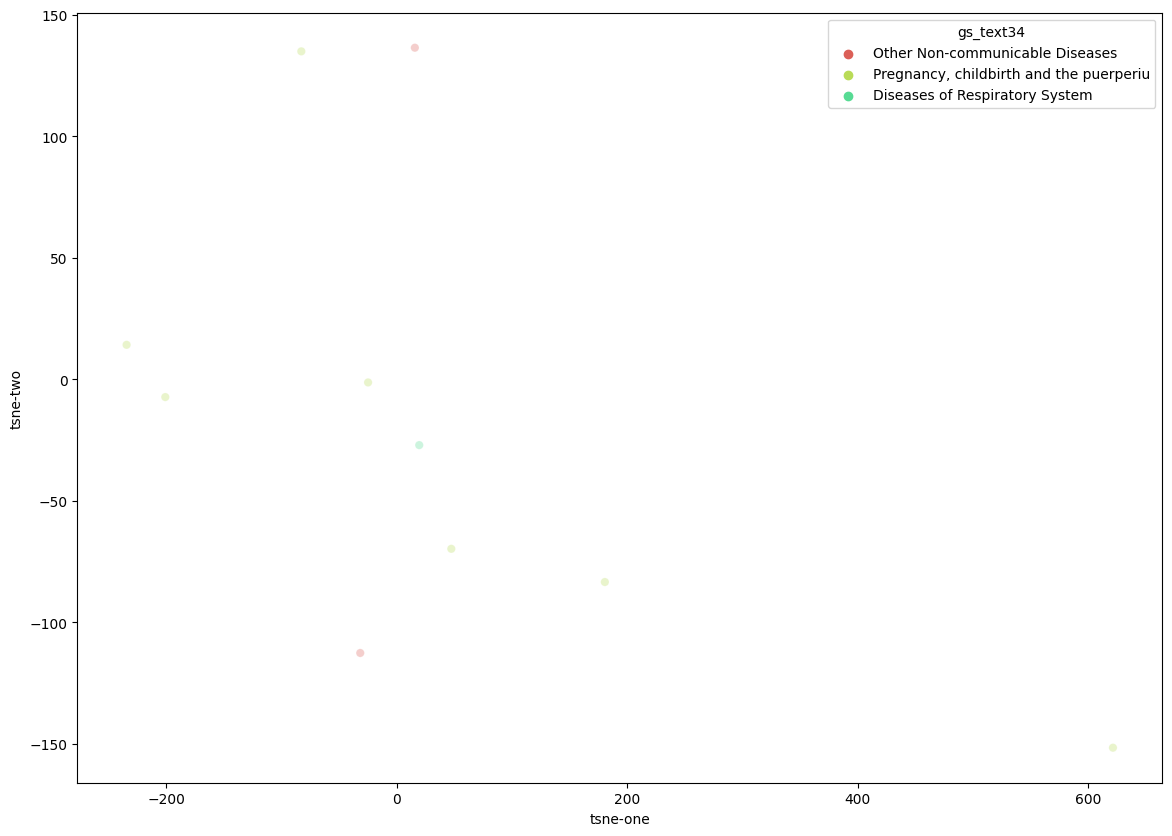

In [38]:
import seaborn as sns

plt.figure(figsize=(14,10))
ax2 = plt.subplot(1, 1, 1)
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="gs_text34",
    palette=sns.color_palette("hls", 5),
    data=data_tsn,
    legend="full",
    alpha=0.3,
    ax=ax2
)

<hr>

<h2>Asignar cluster a cualquier frase</h2>

In [27]:
def cargar_centroides(path):
    data = pd.read_csv(path)
    data = data.iloc[:,1:]

    centroides = {}

    for i in range(len(data.index)):
        centroides[i] = data.iloc[[i]]

    return centroides

In [28]:
from gensim.models.doc2vec import Doc2Vec

def cargar_modelo(path):
    model = Doc2Vec.load(path)
    return model

In [29]:
def preproceso(txt):
    txt = to_minusculas(txt)
    txt = quitar_marcasPuntuacion(txt)
    txt = extender_contracciones(txt)
    txt = to_minusculas(txt)
    txt = lematizar_palabras(txt)
    txt = quitar_stopwords(txt)
    txt = quitar_espaciosExtra(txt)

    return txt
      

In [46]:
def asignar_cluster_str(word, idioma='en'):

    word = str(word)

    if idioma == 'es':
        word = traducir_esp2ing('en')

    centroides = cargar_centroides('data_output/centroides_kmeans.csv')
    modelo = cargar_modelo('model/doc2vec.model')

    dataACS = preproceso(word)

    words = dataACS.split(" ")

    pos_word = modelo.infer_vector(words)
    pos_word_df = pd.DataFrame(columns=list(range(100)), index = list(range(1)))
    for i in range(len(pos_word_df.columns)):
        pos_word_df.iloc[0, i] = pos_word[i]

    distancias = {}

    for idx, centroide in centroides.items():
        dst = dist_minkowski(pos_word_df,centroide,3)
        distancias[idx] = dst

    index_min = min(distancias, key=distancias.get) 

    print(f'A la instancia introducida se le ha asignado el cluster {index_min} a una distancia de {distancias[index_min]}')

    return index_min, pos_word_df

In [47]:
#asignar_cluster_str('Texto a analizar para probar que cluster se le asigna, en ingles', 'es')
asignar_cluster_str('the death occurred due to burning')

A la instancia introducida se le ha asignado el cluster 0 a una distancia de 0.016170891926821675


(0,
            0           1            2            3           4           5   \
 0  0.00343779 -0.00171717  0.000740585 -0.000179651  0.00341067  0.00217389   
 
             6           7           8            9   ...           90  \
 0  0.000209754  0.00378049 -0.00477357 -0.000132354  ...  0.000245413   
 
            91          92          93          94          95          96  \
 0 -0.00389513  0.00179026  0.00277517  0.00434403 -0.00119647  0.00483865   
 
            97          98        99  
 0  0.00447062  0.00478459  0.001554  
 
 [1 rows x 100 columns])

<hr>

<h2>Documentos similares para cualquier frase</h2>

In [50]:
def docs_similares(word, idioma='en'):

    word = str(word)

    cluster_asignado, posicion_instancia = asignar_cluster_str('Texto a analizar para probar que cluster se le asigna, en ingles', idioma)

    data_path = "data_cluster/cluster" + str(cluster_asignado) + ".csv"
    data_pos = pd.read_csv(data_path)
    #y = data_pos.drop(data_pos.columns[[0]], axis=1, inplace=True)
    data_pos.drop(data_pos.columns[[0]], axis=1, inplace=True)
    y = list(range(len(data_pos)))

    distancias = {}
    idx = 0
    #for instance in data_pos.iterrows():
    for i in range(len(data_pos)):
        instancia = data_pos.iloc[[i]]
        # print(instancia)
        # print(posicion_instancia)
        dst = dist_minkowski(instancia,posicion_instancia, 3)
        #distancias[y[idx]] = dst
        distancias[i] = dst
        #idx += 1

    print(f"distancias: {distancias}")
    masSimilares = sorted(distancias, key=distancias.get)[:5] # pone que hay que elegirlo con un parámetro
    print(f"distancias ordenadas: {masSimilares}")

    #for key, value in distancias.items:
    documentos_similares = {}
    open_response = pd.read_csv("data_output/preproceso.csv")['open_response']
    print(type(open_response))
    for key in masSimilares:
        documentos_similares[key] = open_response.loc[key]
        #distancias[key] = data[key]['open_response']

    #return distancias
    return documentos_similares

In [52]:
#clase, docs = docs_similares('la muerte la cuaso una quemadura del incendio', 'es')
#clase, docs = docs_similares('the death occurred due to burning', 'en')
docs = docs_similares('the death occurred due to burning', 'en')
print(f"\n{docs}")

A la instancia introducida se le ha asignado el cluster 0 a una distancia de 0.017058825497116032
distancias: {0: 0.022464408857724927, 1: 0.020612203439858385, 2: 0.02246963578497997, 3: 0.02218145183196868, 4: 0.02220896666767849, 5: 0.023845939171191363, 6: 0.023040440205858746}
distancias ordenadas: [1, 3, 4, 0, 2]
<class 'pandas.core.series.Series'>

{1: 'caese death pneumonia', 3: 'went work sunday iron rod brother person went hold rod rod touched electric wire got electric shock took hospital wa nobody house death co worker informed u death', 4: 'deceased died due snake bite deceased regained conscious hour death doctor said deceased gone coma deceased completely healthy', 0: 'date felt lower back pain fever went hospital place doctor wa suspecting arthritis wa ordered x ray went hospital lab result normal suddenly complained difficulty breathing doctor said ha pneumonia oxygen inhalation wa started still wa weak blood sugar wa elevated died ff day', 2: 'took wife private hospit